# Analytics Challenge

Using data from the Household Pulse Survey (HPS) Week 46, my goal was to determine whether or not there are certain factors that can predict why someone would choose not to get the booster even though they already got the COVID vaccine.

This is an extension of the storytelling challenge analysis of why people choose to get the COVID vaccine, but not the booster. 

## Importing

In [1]:
# Initial
import pandas as pd
from scipy import stats

# Classification
import math
import sklearn.linear_model as sklm
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
import scikitplot as skplt
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, \
                            BaggingClassifier, BaggingRegressor, \
                            GradientBoostingRegressor, GradientBoostingClassifier

# Visualization
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (6, 5))

no display found. Using non-interactive Agg backend


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

##### Used -99 and -88 as NA values based on the data dicitonary

In [3]:
pulse = pd.read_csv("pulse2022_puf_46.csv", na_values=["-99","-88"])

# Classification

## Reason Selection

In [ ]:
cats = pulse[(pulse["BOOSTERRV"] == 2)]
cats.reset_index(inplace = True)

In [ ]:
i = 0

while(i < len(cats)):
    j = 1
    while(j < 10):
        if(cats.loc[i, f"WHYNOBSTR{j}"] == 1):
            cats = pd.concat([cats, pd.DataFrame.from_records([{ 'Reason': j }])], ignore_index=True)
        j += 1
    i += 1

In [ ]:
cats["Reason"].value_counts()

3.0    3671
2.0    2975
5.0    2847
7.0    1574
6.0    1507
9.0    1095
4.0     707
1.0     498
8.0     183
Name: Reason, dtype: int64

## Cleaning Data for Classification
* Created columns for reasons 2, 3, and 5
* Cleaned data for modeling

In [44]:
pulse.head()

,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,AHISPANIC,RRACE,ARACE,EEDUC,AEDUC,MS,EGENID_BIRTH,AGENID_BIRTH,GENID_DESCRIBE,SEXUAL_ORIENTATION,THHLD_NUMPER,AHHLD_NUMPER,THHLD_NUMKID,AHHLD_NUMKID,THHLD_NUMADLT,KIDS_LT5Y,KIDS_5_11Y,KIDS_12_17Y,ENRPUBCHK,ENRPRVCHK,ENRHMSCHK,TENROLLPUB,TENROLLPRV,TENROLLHMSCH,ENROLLNONE,ACTVDUTY1,ACTVDUTY2,ACTVDUTY3,ACTVDUTY4,ACTVDUTY5,RECVDVACC,NUMDOSES,BOOSTERRV,WHYNOBSTR1,WHYNOBSTR2,WHYNOBSTR3,WHYNOBSTR4,WHYNOBSTR5,WHYNOBSTR6,WHYNOBSTR7,WHYNOBSTR8,WHYNOBSTR9,KIDDOSESRV,KIDDOSESRV_LT5Y,KIDDOSESRV_5_11Y,KIDDOSESRV_12_17Y,KIDBSTR_LT5Y,KIDBSTR_5_11Y,KIDBSTR_12_17Y,KIDGETVAC_LT5Y,KIDGETVAC_5_11Y,KIDGETVAC_12_17Y,KIDWHYNO1,KIDWHYNO2,KIDWHYNO3,KIDWHYNO4,KIDWHYNO5,KIDWHYNO6,KIDWHYNO7,KIDWHYNO8,KIDWHYNO9,KIDWHYNO10,KIDWHYNO11,KIDWHYNO12,KIDWHYNO13,KIDWHYNO14,HADCOVIDRV,WHENCOVID,TREATORAL,TREATMONO,RSNNOTREAT1,RSNNOTREAT2,RSNNOTREAT3,RSNNOTREAT4,RSNNOTREAT5,RSNNOTREAT6,RSNNOTREAT7,RSNNOTREAT8,RSNNOTREAT9,RSNNOTREAT10,SYMPTOMS,LONGCOVID,SYMPTMNOW,WRKLOSSRV,ANYWORK,KINDWORK,RSNNOWRKRV,WKVOL,SETTING,UI_APPLYRV,UI_RECVRV,UI_RECVNOW,CHLDCARE,CHLDIMPCT1,CHLDIMPCT2,CHLDIMPCT3,CHLDIMPCT4,CHLDIMPCT5,CHLDIMPCT6,CHLDIMPCT7,CHLDIMPCT8,CHLDIMPCT9,CTC_CLAIM,CTC_REFUND,CTC_USE,CTCSPND1,CTCSPND2,CTCSPND3,CTCSPND4,CTCSPND5,CTCSPND6,CTCSPND7,CTCSPND8,CTCSPND9,CTCSPND10,CTCSPND11,CTCSPND12,CTCSPND13,CTCSPND14,CTCSPND15,CTCSPND16,CTCSPND17,EXPNS_DIF,TWDAYS,SPND_SRC1,SPND_SRC2,SPND_SRC3,SPND_SRC4,SPND_SRC5,SPND_SRC6,SPND_SRC7,SPND_SRC8,SPND_SRC9,SPND_SRC10,SPND_SRC11,SPND_SRC12,TSPNDFOOD,TSPNDPRPD,CURFOODSUF,CHILDFOOD,FOODRSNRV1,FOODRSNRV2,FOODRSNRV3,FOODRSNRV4,FREEFOOD,SCHLFDHLP1,SCHLFDHLP2,SCHLFDHLP3,SCHLFDHLP4,NOSCHLFDHLP,SNAP_YN,ANXIOUS,WORRY,INTEREST,DOWN,HLTHINS1,HLTHINS2,HLTHINS3,HLTHINS4,HLTHINS5,HLTHINS6,HLTHINS7,HLTHINS8,PRIVHLTH,PUBHLTH,TELEHLTH,TH_ADLT_PHON,TH_ADLT_VID,TELECHLD,TH_CHLD_PHON,TH_CHLD_VID,KIDBHVR1,KIDBHVR2,KIDBHVR3,KIDBHVR4,KIDBHVR5,KIDBHVR6,KIDBHVR7,KIDBHVR8,KIDBHVR9,SEEING,HEARING,REMEMBERING,MOBILITY,SELFCARE,UNDERSTAND,TENURE,TRENTAMT,RENTCHNG,LIVQTRRV,RENTCUR,MORTCUR,TMNTHSBHND,RENTASSIST,EVICT,FORCLOSE,ENERGY,HSE_TEMP,ENRGY_BILL,PRVRIDESHR,FEWRTRANS,RCVEDUC1,RCVEDUC2,RCVEDUC3,RCVEDUC4,RCVEDUC5,RCVEDUC6,RCVEDUC7,RCVEDUC8,RCVEDUC9,LEARNFMT,SCHLHRS,TNUM_PS,PSCHNG1,PSCHNG2,PSCHNG3,PSCHNG4,PSCHNG5,PSCHNG6,PSCHNG7,PSWHYCHG1,PSWHYCHG2,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,INCOME
0,V460000001,46,40,NaN,2,1609.416500,2991.171369,1994,2,1,2,1,2,7,2,1.0,2,2,2.0,2.0,3,2,1,2,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.0,2.0,1.0,1.0,NaN,2.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.0,50.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,4.0,4.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1,V460000002,46,27,NaN,3,677.420313,1315.182329,1950,2,1,2,1,2,6,2,1.0,1,2,1.0,2.0,2,2,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,7.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,Na

In [4]:
noBoost = pulse[(pulse["BOOSTERRV"] == 2)]
noBoost.reset_index(inplace = True)

In [5]:
i = 0
while(i < len(noBoost)):
    j = 1
    while(j < 10):
        if(noBoost.loc[i, "WHYNOBSTR2"] == 1):
            noBoost.loc[i, "Reason2"] = 1
        else:
            noBoost.loc[i, "Reason2"] = 0
        
        if(noBoost.loc[i, "WHYNOBSTR3"] == 1):
            noBoost.loc[i, "Reason3"] = 1
        else:
            noBoost.loc[i, "Reason3"] = 0
            
        if(noBoost.loc[i, "WHYNOBSTR5"] == 1):
            noBoost.loc[i, "Reason5"] = 1
        else:
            noBoost.loc[i, "Reason5"] = 0
            
        j += 1
    i += 1

/var/folders/61/zxwl6cdd4hj6rqs1s7tbw4lc0000gn/T/ipykernel_31755/3768765256.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noBoost.loc[i, "Reason2"] = 0
/var/folders/61/zxwl6cdd4hj6rqs1s7tbw4lc0000gn/T/ipykernel_31755/3768765256.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noBoost.loc[i, "Reason3"] = 0
/var/folders/61/zxwl6cdd4hj6rqs1s7tbw4lc0000gn/T/ipykernel_31755/3768765256.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [93]:
noBoost["Reason2"].value_counts()

0.0    7458
1.0    2975
Name: Reason2, dtype: int64

In [94]:
noBoost["Reason3"].value_counts()

0.0    6762
1.0    3671
Name: Reason3, dtype: int64

In [95]:
noBoost["Reason5"].value_counts()

0.0    7586
1.0    2847
Name: Reason5, dtype: int64

##### Removed columns that had continous responses

In [6]:
noBoost.drop(["THHLD_NUMPER", "THHLD_NUMKID", "THHLD_NUMADLT",
             "TENROLLPUB", "TENROLLPRV", "TENROLLHMSCH", "WEEK",
             "TRENTAMT", "EST_MSA", "PWEIGHT", "HWEIGHT", "SCRAM"],
             axis = 1, inplace = True)

/var/folders/61/zxwl6cdd4hj6rqs1s7tbw4lc0000gn/T/ipykernel_31755/415348666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noBoost.drop(["THHLD_NUMPER", "THHLD_NUMKID", "THHLD_NUMADLT",


##### Checked which columns had the most NA values

In [128]:
all_data_na = (noBoost.isnull().sum() / len(noBoost)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:len(noBoost)]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
KIDGETVAC_LT5Y,100.000000
KIDBSTR_5_11Y,100.000000
KIDBSTR_LT5Y,100.000000
KIDDOSESRV_LT5Y,100.000000
KIDWHYNO9,99.961660
SCHLFDHLP4,99.904150
RSNNOTREAT8,99.904150
RSNNOTREAT7,99.904150
CTCSPND6,99.894565
CTCSPND15,99.846640


In [7]:
noBoostCln = noBoost.copy()

for column in noBoostCln:
    if((noBoostCln[column].isna().sum() / len(noBoostCln)) < 0.9):
        mean=noBoostCln[column].mean()
        noBoostCln[column].fillna(value=mean, inplace=True)
    else:
        noBoostCln[column].fillna(value=0, inplace=True)

In [130]:
noBoostCln.isna().sum()

index                 0
EST_ST                0
REGION                0
TBIRTH_YEAR           0
ABIRTH_YEAR           0
RHISPANIC             0
AHISPANIC             0
RRACE                 0
ARACE                 0
EEDUC                 0
AEDUC                 0
MS                    0
EGENID_BIRTH          0
AGENID_BIRTH          0
GENID_DESCRIBE        0
SEXUAL_ORIENTATION    0
AHHLD_NUMPER          0
AHHLD_NUMKID          0
KIDS_LT5Y             0
KIDS_5_11Y            0
KIDS_12_17Y           0
ENRPUBCHK             0
ENRPRVCHK             0
ENRHMSCHK             0
ENROLLNONE            0
ACTVDUTY1             0
ACTVDUTY2             0
ACTVDUTY3             0
ACTVDUTY4             0
ACTVDUTY5             0
RECVDVACC             0
NUMDOSES              0
BOOSTERRV             0
WHYNOBSTR1            0
WHYNOBSTR2            0
WHYNOBSTR3            0
WHYNOBSTR4            0
WHYNOBSTR5            0
WHYNOBSTR6            0
WHYNOBSTR7            0
WHYNOBSTR8            0
WHYNOBSTR9      

## Variable Selection
* Used forward selection (Where applicable)

In [99]:
tr_X_col = noBoostCln.columns.values.tolist()
tr_X_col.remove("Reason2")
tr_X_col.remove("Reason3")
tr_X_col.remove("Reason5")

X = noBoostCln[tr_X_col]
y = noBoostCln["Reason5"]

In [105]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

### Forward Selection
* Used for reason 2 and 3

In [121]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = sklm.LogisticRegression(solver='liblinear')
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()*0] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: index, EST_ST, REGION, TBIRTH_YEAR, ABIRTH_YEAR, RHISPANIC, AHISPANIC, RRACE, ARACE, EEDUC, AEDUC, MS, EGENID_BIRTH, AGENID_BIRTH, GENID_DESCRIBE, SEXUAL_ORIENTATION, AHHLD_NUMPER, AHHLD_NUMKID, KIDS_LT5Y, KIDS_5_11Y, KIDS_12_17Y, ENRPUBCHK, ENRPRVCHK, ENRHMSCHK, ENROLLNONE, ACTVDUTY1, ACTVDUTY2, ACTVDUTY3, ACTVDUTY4, ACTVDUTY5, RECVDVACC, NUMDOSES, BOOSTERRV, WHYNOBSTR1, WHYNOBSTR2, WHYNOBSTR3, WHYNOBSTR4, WHYNOBSTR5, WHYNOBSTR6, WHYNOBSTR7, WHYNOBSTR8, WHYNOBSTR9, KIDDOSESRV, KIDDOSESRV_LT5Y, KIDDOSESRV_5_11Y, KIDDOSESRV_12_17Y, KIDBSTR_LT5Y, KIDBSTR_5_11Y, KIDBSTR_12_17Y, KIDGETVAC_LT5Y, KIDGETVAC_5_11Y, KIDGETVAC_12_17Y, KIDWHYNO1, KIDWHYNO2, KIDWHYNO3, KIDWHYNO4, KIDWHYNO5, KIDWHYNO6, KIDWHYNO7, KIDWHYNO8, KIDWHYNO9, KIDWHYNO10, KIDWHYNO11, KIDWHYNO12, KIDWHYNO13, KIDWHYNO14, TREATORAL, TREATMONO, RSNNOTREAT9, RSNNOTREAT10, WRKLOSSRV, ANYWORK, KINDWORK, RSNNOWRKRV, WKVOL, SETTING, UI_APPLYRV, UI_RECVRV, UI_RECVNOW, CHLDCARE, CHLDIMPCT1, CHLDIMPCT2, CHLDIMPCT3, CHLDIMPCT

In [17]:
classificationSummary(test_y, best_model.predict(test_X[best_variables]))

Confusion Matrix (Accuracy 0.7385)

       Prediction
Actual   0   1
     0 712  44
     1 229  59


## Modeling
* Created confusion matricies and importance graphs for each reason based on model
* Then tested model with validation data

### Reason 2

#### Variables

In [8]:
columns2 = ['RSNNOTREAT6', 'WHYNOBSTR1', 'CTCSPND15', 'WHYNOBSTR7', 'RCVEDUC4', 'REGION', 'FOODRSNRV3', 
           'WHYNOBSTR9', 'WHYNOBSTR4', 'PSWHYCHG5', 'CTCSPND2', 'KIDGETVAC_5_11Y', 'SELFCARE', 'RHISPANIC', 
           'WHYNOBSTR6', 'KIDWHYNO4', 'KIDBHVR6', 'HSE_TEMP', 'SPND_SRC8', 'WHYNOBSTR8', 'SEXUAL_ORIENTATION', 
           'KIDWHYNO11', 'CHLDIMPCT2', 'RSNNOTREAT5', 'KIDWHYNO9', 'ABIRTH_YEAR', 'CHLDIMPCT8', 'RCVEDUC5', 
           'CHLDIMPCT9', 'HLTHINS7', 'EST_ST', 'RCVEDUC6']

In [9]:
tr_X_col = columns2

X = noBoostCln[tr_X_col]
y = noBoostCln["Reason2"]

#### Training

In [10]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [11]:
reason2Bag = RandomForestClassifier(max_features=None, random_state=23)
reason2Bag.fit(train_X, train_y)
reason2PredTrain = reason2Bag.predict(train_X)

In [12]:
cm = confusion_matrix(train_y, reason2PredTrain)
print("Confusion Matrix:\n", cm)
print("\n")
print("Classification Report:\n",classification_report(train_y, reason2PredTrain))

Confusion Matrix:
 [[5813  162]
 [1230 1141]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      5975
         1.0       0.88      0.48      0.62      2371

    accuracy                           0.83      8346
   macro avg       0.85      0.73      0.76      8346
weighted avg       0.84      0.83      0.82      8346



<AxesSubplot:title={'center':'Reason 2'}, xlabel='Predicted label', ylabel='True label'>

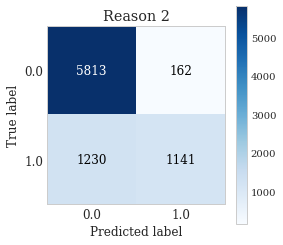

In [14]:
skplt.metrics.plot_confusion_matrix(train_y, reason2PredTrain, figsize=(4,4), cmap="Blues", title="Reason 2")

#### Testing

In [15]:
reason2Pred = reason2Bag.predict(test_X)

In [16]:
cm = confusion_matrix(test_y, reason2Pred)
print("Confusion Matrix:\n", cm)
print("\n")
print("Classification Report:\n",classification_report(test_y, reason2Pred))

Confusion Matrix:
 [[1284  199]
 [ 489  115]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.87      0.79      1483
         1.0       0.37      0.19      0.25       604

    accuracy                           0.67      2087
   macro avg       0.55      0.53      0.52      2087
weighted avg       0.62      0.67      0.63      2087



<AxesSubplot:title={'center':'Reason 2'}, xlabel='Predicted label', ylabel='True label'>

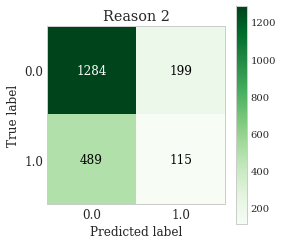

In [17]:
skplt.metrics.plot_confusion_matrix(test_y, reason2Pred, figsize=(4,4), cmap="Greens", title="Reason 2")

#### Importance

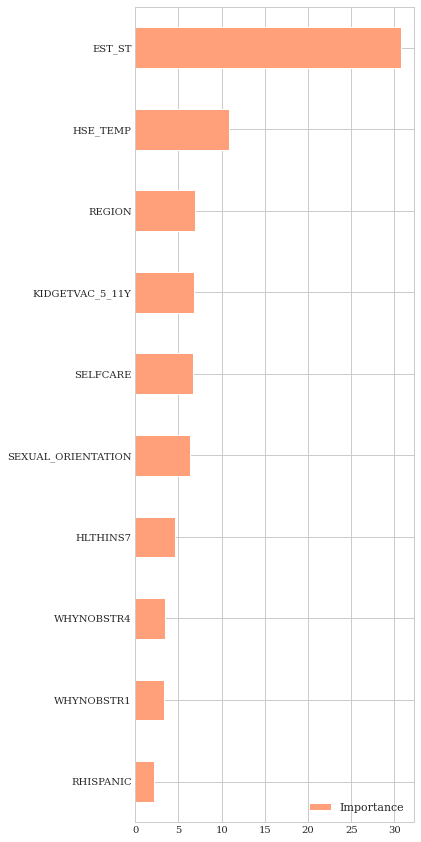

In [18]:
imp = pd.DataFrame({'Importance':reason2Bag.feature_importances_*100}, \
                          index=tr_X_col)
imp.sort_values('Importance', axis=0, ascending=True).tail(10).plot(kind='barh', color='lightsalmon', )
plt.gcf().set_size_inches(5, 15)

#### Understanding Importance

In [66]:
re2 = noBoostCln[(noBoostCln["Reason2"] == 1)]

In [67]:
re2["EST_ST"].value_counts()

48    205
6     194
12    126
13    102
49    100
53     98
4      86
17     78
42     77
51     77
47     75
37     72
18     71
25     71
29     70
45     65
26     64
21     62
39     61
8      59
20     58
24     57
32     57
1      56
19     56
40     55
22     52
16     51
28     49
27     48
41     46
36     43
55     41
9      40
5      38
34     36
31     36
33     33
35     31
38     30
10     29
46     29
15     28
54     28
56     26
2      22
44     21
23     21
30     20
11     16
50      9
Name: EST_ST, dtype: int64

### Reason 3

#### Variables

In [19]:
columns3 = ['KIDWHYNO4', 'WHYNOBSTR6', 'EGENID_BIRTH', 'WHYNOBSTR4', 'KIDWHYNO11', 'RSNNOTREAT1', 'SPND_SRC9', 
           'ARACE', 'ACTVDUTY3', 'SPND_SRC5', 'REGION', 'RCVEDUC3', 'SYMPTMNOW', 'INCOME', 'KIDBHVR9', 'KIDBHVR4', 
           'ACTVDUTY2', 'WRKLOSSRV', 'ACTVDUTY4', 'RSNNOTREAT7', 'KIDWHYNO10', 'KIDBHVR5', 'KIDWHYNO8', 'CTC_REFUND', 
           'RSNNOTREAT10', 'PSCHNG7', 'CTCSPND5']

In [20]:
tr_X_col = columns3

X = noBoostCln[tr_X_col]
y = noBoostCln["Reason3"]

#### Training

In [21]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [22]:
reason3Bag = RandomForestClassifier(max_features=None, random_state=23)
reason3Bag.fit(train_X, train_y)
reason3PredTrain = reason3Bag.predict(train_X)

In [23]:
cm = confusion_matrix(train_y, reason3PredTrain)
print("Confusion Matrix:\n", cm)
print("\n")
print("Classification Report:\n",classification_report(train_y, reason3PredTrain))

Confusion Matrix:
 [[5104  292]
 [1636 1314]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.95      0.84      5396
         1.0       0.82      0.45      0.58      2950

    accuracy                           0.77      8346
   macro avg       0.79      0.70      0.71      8346
weighted avg       0.78      0.77      0.75      8346



<AxesSubplot:title={'center':'Reason 3'}, xlabel='Predicted label', ylabel='True label'>

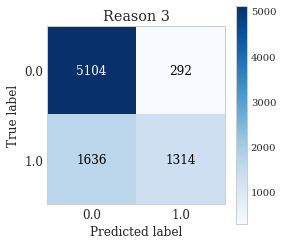

In [28]:
skplt.metrics.plot_confusion_matrix(train_y, reason3PredTrain, figsize=(4,4), cmap="Blues", title="Reason 3")

#### Testing

In [25]:
reason3Pred = reason3Bag.predict(test_X)

In [26]:
cm = confusion_matrix(test_y, reason3Pred)
print("Confusion Matrix:\n", cm)
print("\n")
print("Classification Report:\n",classification_report(test_y, reason3Pred))

Confusion Matrix:
 [[1160  206]
 [ 549  172]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.85      0.75      1366
         1.0       0.46      0.24      0.31       721

    accuracy                           0.64      2087
   macro avg       0.57      0.54      0.53      2087
weighted avg       0.60      0.64      0.60      2087



<AxesSubplot:title={'center':'Reason 3'}, xlabel='Predicted label', ylabel='True label'>

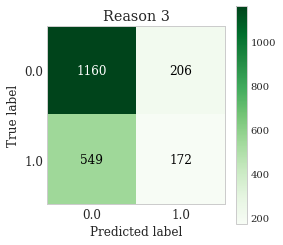

In [29]:
skplt.metrics.plot_confusion_matrix(test_y, reason3Pred, figsize=(4,4), cmap="Greens", title="Reason 3")

#### Importance

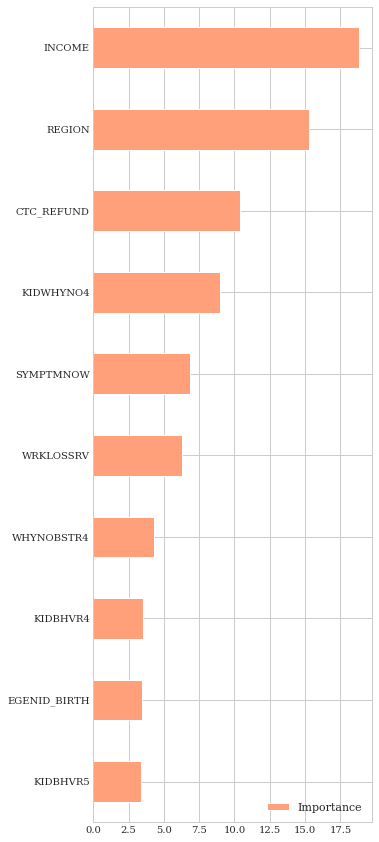

In [30]:
imp = pd.DataFrame({'Importance':reason3Bag.feature_importances_*100}, \
                          index=tr_X_col)
imp.sort_values('Importance', axis=0, ascending=True).tail(10).plot(kind='barh', color='lightsalmon', )
plt.gcf().set_size_inches(5, 15)

#### Understanding Importance

In [63]:
re3 = noBoostCln[(noBoostCln["Reason3"] == 1)]

In [64]:
re3["INCOME"].value_counts()

4.14647    929
6.00000    524
4.00000    435
5.00000    412
1.00000    319
3.00000    313
8.00000    248
7.00000    248
2.00000    243
Name: INCOME, dtype: int64

In [65]:
re3["REGION"].value_counts()

2    1378
4    1027
3     741
1     525
Name: REGION, dtype: int64

### Reason 5

#### Variables

No variables selected, used all variables that did not correspond to having covid already.

In [68]:
tr_X_col = noBoostCln.columns.values.tolist()
tr_X_col.remove("index")
tr_X_col.remove("Reason2")
tr_X_col.remove("Reason3")
tr_X_col.remove("Reason5")
tr_X_col.remove("HADCOVIDRV")
tr_X_col.remove("WHENCOVID")
tr_X_col.remove("SYMPTOMS")
tr_X_col.remove("SYMPTMNOW")
tr_X_col.remove("LONGCOVID")
tr_X_col.remove("TREATORAL")
tr_X_col.remove("TREATMONO")
i = 1
while(i < 9):
    tr_X_col.remove(f"RSNNOTREAT{i}")
    i += 1

X = noBoostCln[tr_X_col]
y = noBoostCln["Reason5"]

#### Training

In [69]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [70]:
reason5Bag = RandomForestClassifier(max_features=None, random_state=23)
reason5Bag.fit(train_X, train_y)
reason5PredTrain = reason5Bag.predict(train_X)

In [71]:
cm = confusion_matrix(train_y, reason5PredTrain)
print("Confusion Matrix:\n", cm)
print("\n")
print("Classification Report:\n",classification_report(train_y, reason5PredTrain))

Confusion Matrix:
 [[6060    0]
 [   0 2286]]


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6060
         1.0       1.00      1.00      1.00      2286

    accuracy                           1.00      8346
   macro avg       1.00      1.00      1.00      8346
weighted avg       1.00      1.00      1.00      8346



<AxesSubplot:title={'center':'Reason 5'}, xlabel='Predicted label', ylabel='True label'>

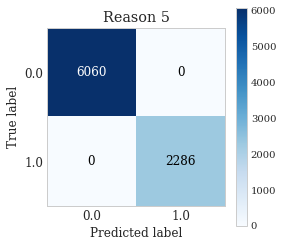

In [72]:
skplt.metrics.plot_confusion_matrix(train_y, reason5PredTrain, figsize=(4,4), cmap="Blues", title="Reason 5")

#### Testing

In [73]:
reason5Pred = reason5Bag.predict(test_X)

In [74]:
cm = confusion_matrix(test_y, reason5Pred)
print("Confusion Matrix:\n", cm)
print("\n")
print("Classification Report:\n",classification_report(test_y, reason5Pred))

Confusion Matrix:
 [[1459   67]
 [ 512   49]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.96      0.83      1526
         1.0       0.42      0.09      0.14       561

    accuracy                           0.72      2087
   macro avg       0.58      0.52      0.49      2087
weighted avg       0.65      0.72      0.65      2087



<AxesSubplot:title={'center':'Reason 5'}, xlabel='Predicted label', ylabel='True label'>

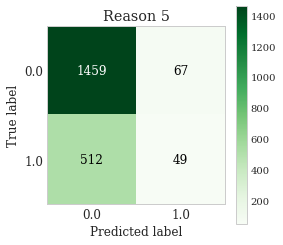

In [75]:
skplt.metrics.plot_confusion_matrix(test_y, reason5Pred, figsize=(4,4), cmap="Greens", title="Reason 5")

#### Importance

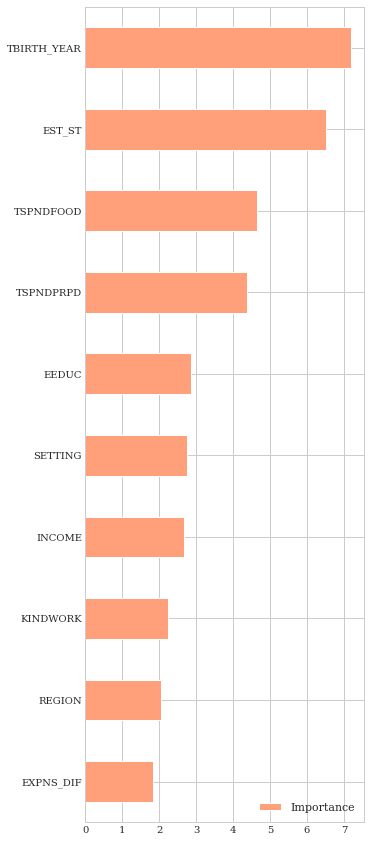

In [76]:
imp = pd.DataFrame({'Importance':reason5Bag.feature_importances_*100}, \
                          index=tr_X_col)
imp.sort_values('Importance', axis=0, ascending=True).tail(10).plot(kind='barh', color='lightsalmon', )
plt.gcf().set_size_inches(5, 15)

#### Understanding Importance

In [77]:
re5 = noBoostCln[(noBoostCln["Reason5"] == 1)]

In [78]:
re5["EST_ST"].value_counts()

48    194
6     150
49    115
12    108
47    103
53     95
13     81
26     80
4      75
51     72
42     71
8      69
16     66
40     65
21     59
18     59
41     59
25     59
17     58
32     57
39     56
36     55
20     54
55     54
34     53
22     50
1      50
29     49
45     47
9      47
5      46
31     46
24     41
37     40
27     39
2      33
56     33
19     31
28     31
54     31
30     30
23     30
33     29
38     29
35     28
46     24
10     23
15     22
44     20
50     16
11     15
Name: EST_ST, dtype: int64

In [80]:
re5["TBIRTH_YEAR"].value_counts()

1983    87
1984    85
1975    82
1970    80
1986    80
1985    77
1974    76
1980    75
1979    74
1982    74
1971    73
1989    72
1977    70
1981    69
1978    68
1969    67
1990    66
1968    64
1988    63
1991    63
1961    61
1972    60
1992    59
1976    58
1987    57
1967    55
1966    54
1995    52
1993    52
1965    45
1994    44
1963    44
1964    43
1962    43
1996    41
1973    41
1958    40
1960    39
1957    35
1955    35
1997    34
1959    32
1998    30
1956    30
1999    28
2000    27
1954    25
1951    25
1953    21
1950    21
1952    20
1949    17
2002    14
2001    11
1946    11
1945    11
2003    11
1947    10
1948     7
2004     7
1944     6
1937     4
1940     4
1938     4
1942     4
1941     4
1934     3
1939     1
1936     1
1935     1
Name: TBIRTH_YEAR, dtype: int64